In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn import svm
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving airlines2.txt to airlines2.txt


In [ ]:
import io
import pandas as pd

# you want to predict

data = pd.read_csv(io.BytesIO(uploaded['airlines2.txt']))

<Axes: >

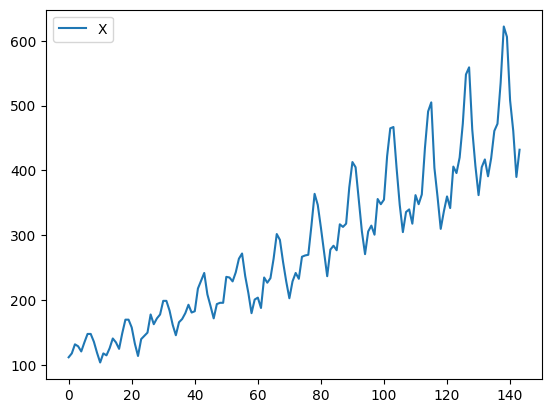

In [ ]:
data.plot()


In [ ]:
len(data)

144

In [ ]:
#Normalizing the data

data_n = data.copy()
data_n = (data - data.min())/(data.max() - data.min())
print(data_n)

            X
0    0.015444
1    0.027027
2    0.054054
3    0.048263
4    0.032819
..        ...
139  0.969112
140  0.779923
141  0.689189
142  0.552124
143  0.633205

[144 rows x 1 columns]


In [ ]:
# TODO: Create function for the Lag used for the prediction
# We will use 12 for the lag dimension if the series repeats 
# itself annually, 3 if it is trimestrial etc.

# Note: For the "ONS" data base, make "dimensions" = 3
# NOTE: For the "Milk" data base, make "dimensions" = 24

dimensions = 3
data_cn = pd.concat([data_n.shift(i) for i in range(0 + dimensions + 1)], axis = 1)

print(data_cn)

            X         X         X         X
0    0.015444       NaN       NaN       NaN
1    0.027027  0.015444       NaN       NaN
2    0.054054  0.027027  0.015444       NaN
3    0.048263  0.054054  0.027027  0.015444
4    0.032819  0.048263  0.054054  0.027027
..        ...       ...       ...       ...
139  0.969112  1.000000  0.832046  0.710425
140  0.779923  0.969112  1.000000  0.832046
141  0.689189  0.779923  0.969112  1.000000
142  0.552124  0.689189  0.779923  0.969112
143  0.633205  0.552124  0.689189  0.779923

[144 rows x 4 columns]


In [ ]:
# Splitting the data into train, validation and test

from sklearn.model_selection import train_test_split

X = data_cn.iloc[12:,1:]

y = data_cn.iloc[12:,0]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.4, shuffle = False)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, shuffle = False)


print(len(y_val))
print(len(y_test))
print(len(y_train))


26
27
79


## PS Optimizater .

In [ ]:
def pso(n_particles, iterations, dimensions, inertia):

    # Range of SVR's hyperparameters (Particles' search space)
    # C, Epsilon and Gamma
    max_c = 1e4
    min_c = 1e-3
    max_e = 1e-1
    min_e = 1e-8
    max_g = 1e3
    min_g = 1e-3
    
    # Initializing particles' positions randomly, inside
    # the search space
    x = np.random.rand(n_particles, 1)*(max_c - min_c) + min_c
    y = np.random.rand(n_particles, 1)*(max_e - min_e) + min_e
    z = np.random.rand(n_particles, 1)*(max_g - min_g) + min_g

    c = np.concatenate((x,y,z), axis=1)

    # Initializing particles' parameters
    v = np.zeros((n_particles, dimensions))
    c1 = 2
    c2 = 2
    p_best = np.zeros((n_particles, dimensions))
    p_best_val = np.zeros(n_particles) + sys.maxsize  
    g_best = np.zeros(dimensions)
    g_best_val = sys.maxsize

    best_iter = np.zeros(iterations)

    # Initializing regression variables
    p_best_RGS = np.empty((n_particles), dtype = object);
    g_best_RGS = sys.maxsize

    

    # Displaying tridimensional search space
    plot(c)

    from sklearn.metrics import mean_squared_error
    
    for i in range(iterations):

        for j in range(n_particles):
          # Starting Regression
          rgs = svm.SVR(C = c[j][0], epsilon = c[j][1], gamma = c[j][2])

          # Fitting the curve
          rgs.fit(X_train, y_train)
          y_predict = rgs.predict(X_val)

          # Using Mean Squared Error to verify prediction accuracy
          mse = mean_squared_error(y_val, y_predict) 

          # If mse value for that search point, for that particle,
          # is less than its personal best point,
          # replace personal best
          if(mse < p_best_val[j]):   # mse < p_best_val[j]
              # The value below represents the current least Mean Squared Error
              p_best_val[j] = mse
              
              p_best_RGS[j] = rgs
                           

              # The value below represents the current search coordinates for
              # the particle's current least Mean Squared Error found
              p_best[j] = c[j].copy()
              
          # Using auxiliar variable to get the index of the
          # particle that found the configuration with the 
          # minimum MSE value
          aux = np.argmin(p_best_val)        
        
          if(p_best_val[aux] < g_best_val):
              # Assigning Particle's current best MSE to the Group's best    
              g_best_val = p_best_val[aux]

              # Assigning Particle's current best configuration to the Group's best
              g_best = p_best[aux].copy()

              # Group best regressor:
              # the combination of C, Epsilon and Gamma
              # that computes the best fitting curve
              g_best_RGS = p_best_RGS[aux]

        
          rand1 = np.random.random()
          rand2 = np.random.random()

          # The variable below influences directly the particle's velocity.
          # It can either make it smaller or bigger. 
          w = inertia

          # The equation below represents Particle's velocity, which is
          # the rate of change in its position
          v[j] = w*v[j] + c1*(p_best[j] - c[j])*rand1 + c2*(g_best - c[j])*rand2

          # Change in the Particle's position 
          c[j] = c[j] + v[j]

          # Below is a series of conditions that stop the particles from
          # leaving the search space
          if(c[j][2] < min_g):
            c[j][2] = min_g
          if(c[j][2] > max_g):
            c[j][2] = max_g
          if(c[j][1] < min_e):
            c[j][1] = min_e
          if(c[j][1] > max_e):
            c[j][1] = max_e
          if(c[j][0] < min_c):
            c[j][0] = min_c
          if(c[j][0] > max_c):
            c[j][0] = max_c
            
     
        # The variable below represents the least Mean Squared Error
        # of the current iteration
        best_iter[i] = g_best_val
                
        print('Best value iteration # %d = %f\n'%(i, g_best_val))

    # Coordinates found after all the iterations
    print('Group Best configuration found: ')
    print(g_best)
    print('\n')
    print('Best Regressor:\n')
    print(g_best_RGS)
    print('\n')
    # Displaying the MSE value variation throughout the iterations
    t = range(iterations)
    plt.plot(t, best_iter, label='Fitness Value')
    plt.legend()
    plt.show()

    # Displaying Particles' final configuration
    plot(c)

    # Making the prediction with the best configuration of C, Epsilon and
    # Gamma found by the particles
    predict_test = g_best_RGS.predict(X_test)

    
    # Displaying actual values and predicted values for
    # Group's best configuration found overall
    print(color.BOLD + 'Predictions with the Population Best Value found:\n' + color.END)
    evaluate(predict_test)  
      


In [ ]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'



In [ ]:
# Function that displays tridimensional plot
def plot(some_list):
 
  ax = Axes3D(plt.figure())
  ax.scatter3D(some_list[:,0], some_list[:,1], some_list[:,2], color = 'r')
  ax.set_xlabel('$C$', fontsize = 20)
  ax.set_ylabel('$\epsilon$', fontsize = 25)
  ax.zaxis.set_rotate_label(False) 
  ax.set_zlabel('$\gamma$', fontsize=30, rotation = 0)
  ax.zaxis._axinfo['label']['space_factor'] = 1.0
  plt.show()

  print('\n')
  print('\n')

In [ ]:
def evaluate(predictions):

    from sklearn.metrics import mean_squared_error
    import statistics as st

    predict_test = predictions

    # To un-normalize the data:
    # Multiply the values by
    # data.to_numpy().max()

    plt.plot(range(len(y_test)), y_test, label='Real')
    plt.plot(range(len(predict_test)), predict_test, label='Predicted')
    plt.legend()
    plt.show()
    
    mse = mean_squared_error(y_test, predict_test)
    print('\n')
    print('\n')
    print('Mean Squared Error for the Test Set:\t %f' %mse)
    print('\n')
    print('\n')
    print('Predictions Average:\t %f' %((predict_test.sum()/len(predict_test))))
    print('\n')
    print('\n')
    print('Predictions Median:\t %f' %(st.median(predict_test)))
    print('\n')
    print('\n')

<Figure size 640x480 with 0 Axes>





Best value iteration # 0 = 0.033722

Best value iteration # 1 = 0.006947

Best value iteration # 2 = 0.006763

Best value iteration # 3 = 0.005983

Best value iteration # 4 = 0.005564

Best value iteration # 5 = 0.005452

Best value iteration # 6 = 0.005452

Best value iteration # 7 = 0.005452

Best value iteration # 8 = 0.005432

Best value iteration # 9 = 0.005432

Best value iteration # 10 = 0.005432

Best value iteration # 11 = 0.005432

Best value iteration # 12 = 0.005432

Best value iteration # 13 = 0.005432

Best value iteration # 14 = 0.005432

Best value iteration # 15 = 0.005432

Best value iteration # 16 = 0.005432

Best value iteration # 17 = 0.005432

Best value iteration # 18 = 0.005432

Best value iteration # 19 = 0.005426

Best value iteration # 20 = 0.005426

Best value iteration # 21 = 0.005426

Best value iteration # 22 = 0.005426

Best value iteration # 23 = 0.005426

Best value iteration # 24 = 0.005426

Best value iteration # 25 = 0.005426

Best value iterati

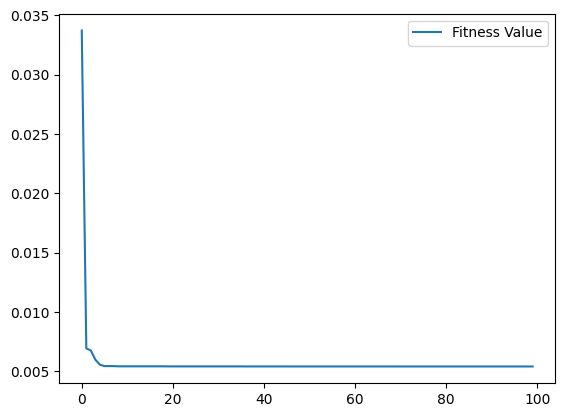

<Figure size 640x480 with 0 Axes>





Predictions with the Population Best Value found:



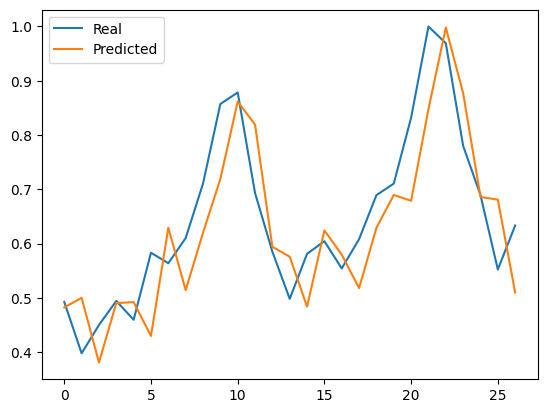





Mean Squared Error for the Test Set:	 0.007941




Predictions Average:	 0.626238




Predictions Median:	 0.619790






In [ ]:
pso(120, 100, 3, 1)

<Figure size 640x480 with 0 Axes>





Best value iteration # 0 = 0.018092

Best value iteration # 1 = 0.005469

Best value iteration # 2 = 0.005455

Best value iteration # 3 = 0.005067

Best value iteration # 4 = 0.005067

Best value iteration # 5 = 0.005067

Best value iteration # 6 = 0.005067

Best value iteration # 7 = 0.005037

Best value iteration # 8 = 0.005037

Best value iteration # 9 = 0.005037

Best value iteration # 10 = 0.005037

Best value iteration # 11 = 0.005037

Best value iteration # 12 = 0.005037

Best value iteration # 13 = 0.005037

Best value iteration # 14 = 0.005037

Best value iteration # 15 = 0.005037

Best value iteration # 16 = 0.004873

Best value iteration # 17 = 0.004873

Best value iteration # 18 = 0.004811

Best value iteration # 19 = 0.004811

Best value iteration # 20 = 0.004811

Best value iteration # 21 = 0.004811

Best value iteration # 22 = 0.004811

Best value iteration # 23 = 0.004811

Best value iteration # 24 = 0.004811

Best value iteration # 25 = 0.004811

Best value iterati

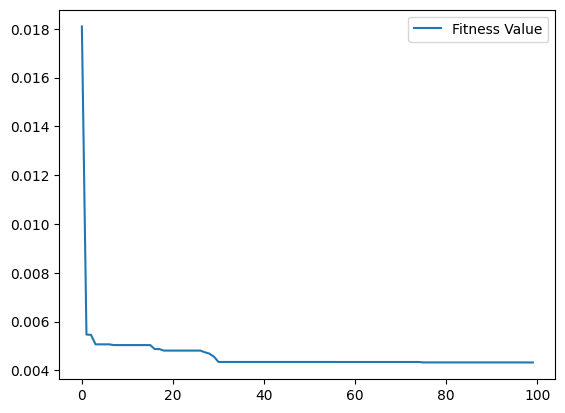

<Figure size 640x480 with 0 Axes>





Predictions with the Population Best Value found:



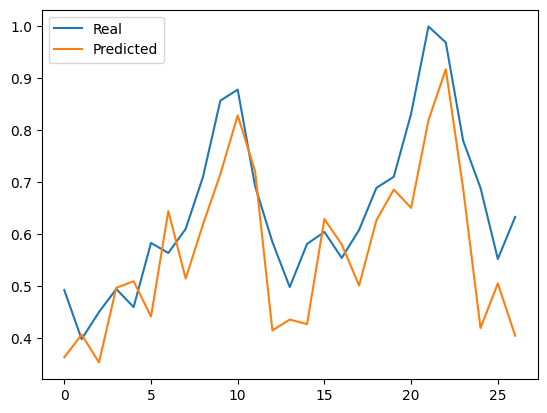





Mean Squared Error for the Test Set:	 0.013873




Predictions Average:	 0.567218




Predictions Median:	 0.514263






In [ ]:
pso(120, 100, 3, 0.8)

<Figure size 640x480 with 0 Axes>





Best value iteration # 0 = 0.029096

Best value iteration # 1 = 0.005702

Best value iteration # 2 = 0.005462

Best value iteration # 3 = 0.005445

Best value iteration # 4 = 0.005441

Best value iteration # 5 = 0.005439

Best value iteration # 6 = 0.005428

Best value iteration # 7 = 0.005428

Best value iteration # 8 = 0.005421

Best value iteration # 9 = 0.005418

Best value iteration # 10 = 0.005418

Best value iteration # 11 = 0.005418

Best value iteration # 12 = 0.005418

Best value iteration # 13 = 0.005418

Best value iteration # 14 = 0.005418

Best value iteration # 15 = 0.005418

Best value iteration # 16 = 0.005418

Best value iteration # 17 = 0.005418

Best value iteration # 18 = 0.005418

Best value iteration # 19 = 0.005418

Best value iteration # 20 = 0.005418

Best value iteration # 21 = 0.005418

Best value iteration # 22 = 0.005418

Best value iteration # 23 = 0.005418

Best value iteration # 24 = 0.005418

Best value iteration # 25 = 0.005418

Best value iterati

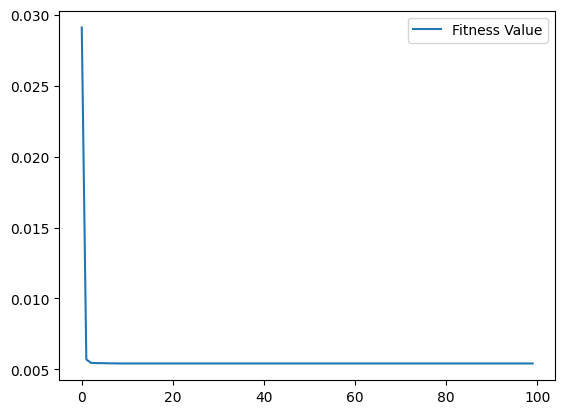

<Figure size 640x480 with 0 Axes>





Predictions with the Population Best Value found:



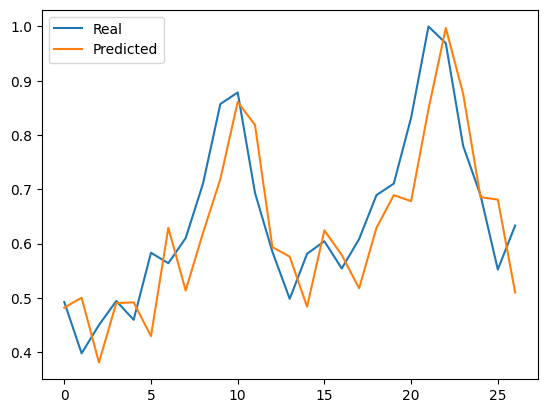





Mean Squared Error for the Test Set:	 0.007956




Predictions Average:	 0.625952




Predictions Median:	 0.619599






In [ ]:
pso(120, 100, 3, 0.6)

<Figure size 640x480 with 0 Axes>





Best value iteration # 0 = 0.034927

Best value iteration # 1 = 0.005738

Best value iteration # 2 = 0.005673

Best value iteration # 3 = 0.005543

Best value iteration # 4 = 0.005477

Best value iteration # 5 = 0.005440

Best value iteration # 6 = 0.005435

Best value iteration # 7 = 0.005430

Best value iteration # 8 = 0.005428

Best value iteration # 9 = 0.005418

Best value iteration # 10 = 0.005418

Best value iteration # 11 = 0.005418

Best value iteration # 12 = 0.005418

Best value iteration # 13 = 0.005418

Best value iteration # 14 = 0.005418

Best value iteration # 15 = 0.005418

Best value iteration # 16 = 0.005418

Best value iteration # 17 = 0.005418

Best value iteration # 18 = 0.005418

Best value iteration # 19 = 0.005418

Best value iteration # 20 = 0.005418

Best value iteration # 21 = 0.005417

Best value iteration # 22 = 0.005417

Best value iteration # 23 = 0.005417

Best value iteration # 24 = 0.005417

Best value iteration # 25 = 0.005417

Best value iterati

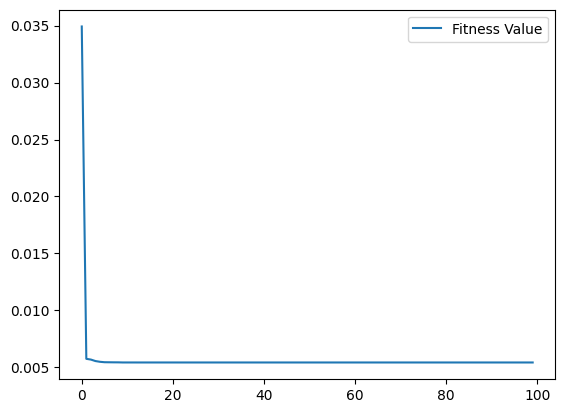

<Figure size 640x480 with 0 Axes>





Predictions with the Population Best Value found:



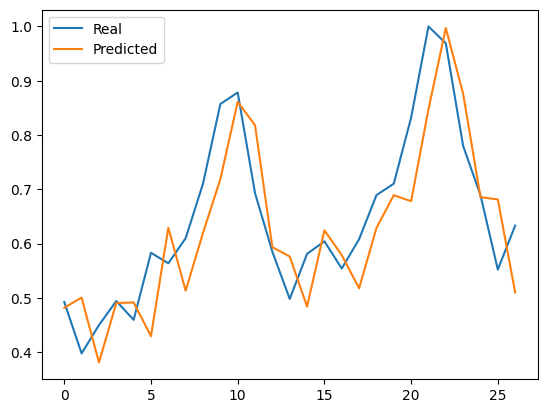





Mean Squared Error for the Test Set:	 0.007957




Predictions Average:	 0.626033




Predictions Median:	 0.619698






In [ ]:
pso(120, 100, 3, 0.2)

## ANT Optimizater ( ACO )

In [ ]:
import numpy as np
from sklearn import svm
from sklearn.metrics import mean_squared_error
import sys

def aco(n_ants, n_iterations, dimensions):

    # Range of SVR's hyperparameters (Particles' search space)
    # C, Epsilon and Gamma
    max_c = 1e4
    min_c = 1e-3
    max_e = 1e-1
    min_e = 1e-8
    max_g = 1e3
    min_g = 1e-3
    
    # Initializing ants' positions randomly, inside
    # the search space
    ants = np.random.rand(n_ants, dimensions)*(max_c - min_c) + min_c
    pheromones = np.zeros(n_ants)
    
    # Initializing ants' parameters
    alpha = 1
    beta = 1
    evaporation_rate = 0.5
    q = 1
    best_ant = None
    best_ant_val = sys.maxsize
    best_iter = np.zeros(n_iterations)
    
    # Initializing regression variables
    best_RGS = None
    
    # Displaying tridimensional search space
    plot(ants)
    
    for i in range(n_iterations):
        
        # Initialize pheromone level to zero
        pheromones.fill(0)
        
        for j in range(n_ants):
            # Starting Regression
            rgs = svm.SVR(C = ants[j][0], epsilon = ants[j][1], gamma = ants[j][2])

            # Fitting the curve
            rgs.fit(X_train, y_train)
            y_predict = rgs.predict(X_val)

            # Using Mean Squared Error to verify prediction accuracy
            mse = mean_squared_error(y_val, y_predict) 
            
            # If mse value for that search point, for that ant,
            # is less than its personal best point,
            # replace personal best
            if(mse < pheromones[j]):   
                # The value below represents the current least Mean Squared Error
                pheromones[j] = mse
                
                # The value below represents the current search coordinates for
                # the ant's current least Mean Squared Error found
                ant_pos = ants[j].copy()
                
                # The regressor that minimizes MSE for this ant
                ant_RGS = rgs
                
                # If mse value is the smallest so far for all the ants,
                # update the best ant configuration
                if mse < best_ant_val:
                    best_ant_val = mse
                    best_ant = ant_pos.copy()
                    best_RGS = ant_RGS
                  
        # Evaporate pheromone
        pheromones *= evaporation_rate
        
        # Update pheromones based on ant's performance
        for j in range(n_ants):
            denominator = 0
            for k in range(n_ants):
                denominator += np.exp(-1*beta*pheromones[k]/(ants[k][0]*ants[k][1]*ants[k][2]))
            numerator = np.exp(-1*beta*pheromones[j]/(ants[j][0]*ants[j][1]*ants[j][2]))
            pheromones[j] = (1-evaporation_rate)*pheromones[j] + q*numerator/denominator
        
           # Generate new ants
        for j in range(n_ants):
            r = np.random.rand()
            if r <= 0.33:
                ants[j][0] += 1
            elif r <= 0.67:
                ants[j][1] += 1
            else:
                ants[j][2] += 1
        
    #     # Check if any ant has found the food
    #     for j in range(n_ants):
    #         if ants[j][0] == food_location[0] and ants[j][1] == food_location[1] and ants[j][2] == food_location[2]:
    #             return ants[j], iteration
        
    #     iteration += 1

    # # Return best ant if food not found
    # max_pheromone_index = np.argmax(pheromones)
    # return ants[max_pheromone_index], max_iterations


In [ ]:
aco(100,5,3)

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np

# define the objective function
def objective_function(x):
    return sum(x**2)

# define the ant optimization function
def ant_optimization(objective_function, lb, ub, max_iter, num_ants):
    # initialize parameters
    dim = len(lb)
    best_solution = None
    best_fitness = np.inf
    pheromone = np.ones(dim) / dim
    trail = np.zeros(dim)
    ants = np.zeros((num_ants, dim))
    
    # start the optimization process
    for i in range(max_iter):
        for j in range(num_ants):
            # generate a new solution
            ants[j] = lb + (ub - lb) * np.random.rand(dim)
            # evaluate the fitness of the solution
            fitness = objective_function(ants[j])
            # check if the solution is better than the best solution so far
            if fitness < best_fitness:
                best_solution = ants[j]
                best_fitness = fitness
            # update the pheromone trail
            trail = (1 - pheromone) * trail + pheromone * (1 / fitness)
            # update the pheromone levels
            pheromone = pheromone + trail / num_ants
        
    return best_solution, best_fitness

# define the bounds of the search space
lb = np.array([-5, -5])
ub = np.array([5, 5])

# run the ant optimization algorithm
best_solution, best_fitness = ant_optimization(objective_function, lb, ub, max_iter=100, num_ants=10)

# print the results
print('Best solution:', best_solution)
print('Best fitness:', best_fitness)


Best solution: [2.19807386 4.31004499]
Best fitness: 0.012816571189398066


<ipython-input-56-76aacca7e131>:29: RuntimeWarning: overflow encountered in multiply
  trail = (1 - pheromone) * trail + pheromone * (1 / fitness)


Started : ACS
Ended : ACS
Sequence : <- 7 - 15 - 11 - 10 - 12 - 13 - 6 - 3 - 1 - 5 - 14 - 8 - 2 - 4 - 9 ->
Total distance travelled to complete the tour : 3199.01



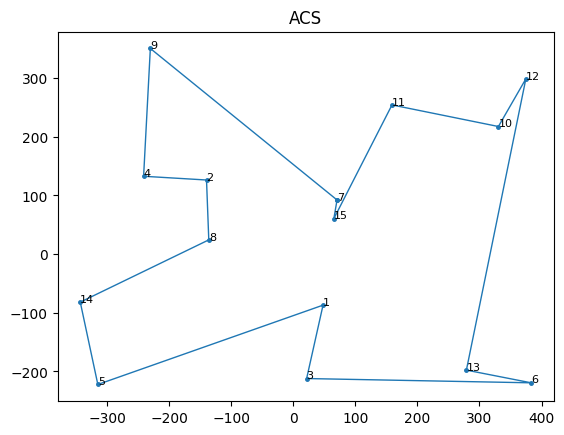

Started : Elitist
Ended : Elitist
Sequence : <- 1 - 15 - 7 - 11 - 10 - 12 - 9 - 4 - 2 - 8 - 14 - 5 - 3 - 13 - 6 ->
Total distance travelled to complete the tour : 3099.88



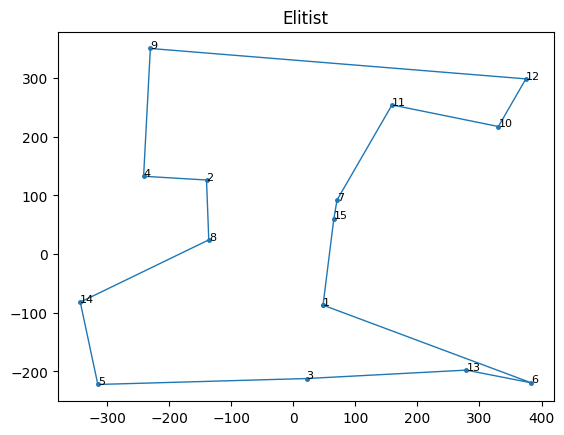

Started : MaxMin
Ended : MaxMin
Sequence : <- 1 - 8 - 2 - 9 - 4 - 14 - 5 - 3 - 13 - 6 - 10 - 12 - 11 - 7 - 15 ->
Total distance travelled to complete the tour : 2977.38



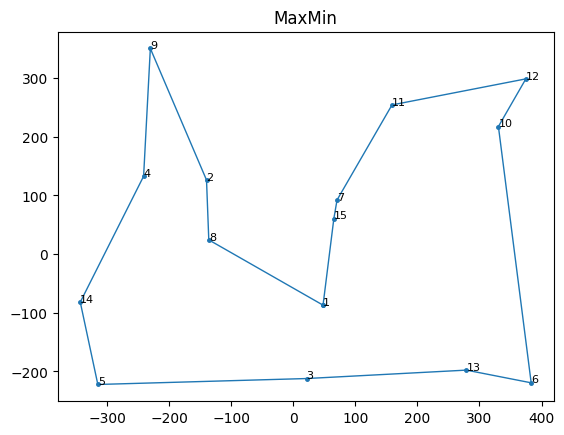

<Figure size 640x480 with 0 Axes>

In [ ]:
import math
import random
from matplotlib import pyplot as plt


class SolveTSPUsingACO:
    class Edge:
        def __init__(self, a, b, weight, initial_pheromone):
            self.a = a
            self.b = b
            self.weight = weight
            self.pheromone = initial_pheromone

    class Ant:
        def __init__(self, alpha, beta, num_nodes, edges):
            self.alpha = alpha
            self.beta = beta
            self.num_nodes = num_nodes
            self.edges = edges
            self.tour = None
            self.distance = 0.0

        def _select_node(self):
            roulette_wheel = 0.0
            unvisited_nodes = [node for node in range(self.num_nodes) if node not in self.tour]
            heuristic_total = 0.0
            for unvisited_node in unvisited_nodes:
                heuristic_total += self.edges[self.tour[-1]][unvisited_node].weight
            for unvisited_node in unvisited_nodes:
                roulette_wheel += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
            random_value = random.uniform(0.0, roulette_wheel)
            wheel_position = 0.0
            for unvisited_node in unvisited_nodes:
                wheel_position += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
                if wheel_position >= random_value:
                    return unvisited_node

        def find_tour(self):
            self.tour = [random.randint(0, self.num_nodes - 1)]
            while len(self.tour) < self.num_nodes:
                self.tour.append(self._select_node())
            return self.tour

        def get_distance(self):
            self.distance = 0.0
            for i in range(self.num_nodes):
                self.distance += self.edges[self.tour[i]][self.tour[(i + 1) % self.num_nodes]].weight
            return self.distance

    def __init__(self, mode='ACS', colony_size=10, elitist_weight=1.0, min_scaling_factor=0.001, alpha=1.0, beta=3.0,
                 rho=0.1, pheromone_deposit_weight=1.0, initial_pheromone=1.0, steps=100, nodes=None, labels=None):
        self.mode = mode
        self.colony_size = colony_size
        self.elitist_weight = elitist_weight
        self.min_scaling_factor = min_scaling_factor
        self.rho = rho
        self.pheromone_deposit_weight = pheromone_deposit_weight
        self.steps = steps
        self.num_nodes = len(nodes)
        self.nodes = nodes
        if labels is not None:
            self.labels = labels
        else:
            self.labels = range(1, self.num_nodes + 1)
        self.edges = [[None] * self.num_nodes for _ in range(self.num_nodes)]
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                self.edges[i][j] = self.edges[j][i] = self.Edge(i, j, math.sqrt(
                    pow(self.nodes[i][0] - self.nodes[j][0], 2.0) + pow(self.nodes[i][1] - self.nodes[j][1], 2.0)),
                                                                initial_pheromone)
        self.ants = [self.Ant(alpha, beta, self.num_nodes, self.edges) for _ in range(self.colony_size)]
        self.global_best_tour = None
        self.global_best_distance = float("inf")

    def _add_pheromone(self, tour, distance, weight=1.0):
        pheromone_to_add = self.pheromone_deposit_weight / distance
        for i in range(self.num_nodes):
            self.edges[tour[i]][tour[(i + 1) % self.num_nodes]].pheromone += weight * pheromone_to_add

    def _acs(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)

    def _elitist(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            self._add_pheromone(self.global_best_tour, self.global_best_distance, weight=self.elitist_weight)
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)

    def _max_min(self):
        for step in range(self.steps):
            iteration_best_tour = None
            iteration_best_distance = float("inf")
            for ant in self.ants:
                ant.find_tour()
                if ant.get_distance() < iteration_best_distance:
                    iteration_best_tour = ant.tour
                    iteration_best_distance = ant.distance
            if float(step + 1) / float(self.steps) <= 0.75:
                self._add_pheromone(iteration_best_tour, iteration_best_distance)
                max_pheromone = self.pheromone_deposit_weight / iteration_best_distance
            else:
                if iteration_best_distance < self.global_best_distance:
                    self.global_best_tour = iteration_best_tour
                    self.global_best_distance = iteration_best_distance
                self._add_pheromone(self.global_best_tour, self.global_best_distance)
                max_pheromone = self.pheromone_deposit_weight / self.global_best_distance
            min_pheromone = max_pheromone * self.min_scaling_factor
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)
                    if self.edges[i][j].pheromone > max_pheromone:
                        self.edges[i][j].pheromone = max_pheromone
                    elif self.edges[i][j].pheromone < min_pheromone:
                        self.edges[i][j].pheromone = min_pheromone

    def run(self):
        print('Started : {0}'.format(self.mode))
        if self.mode == 'ACS':
            self._acs()
        elif self.mode == 'Elitist':
            self._elitist()
        else:
            self._max_min()
        print('Ended : {0}'.format(self.mode))
        print('Sequence : <- {0} ->'.format(' - '.join(str(self.labels[i]) for i in self.global_best_tour)))
        print('Total distance travelled to complete the tour : {0}\n'.format(round(self.global_best_distance, 2)))

    def plot(self, line_width=1, point_radius=math.sqrt(2.0), annotation_size=8, dpi=120, save=True, name=None):
        x = [self.nodes[i][0] for i in self.global_best_tour]
        x.append(x[0])
        y = [self.nodes[i][1] for i in self.global_best_tour]
        y.append(y[0])
        plt.plot(x, y, linewidth=line_width)
        plt.scatter(x, y, s=math.pi * (point_radius ** 2.0))
        plt.title(self.mode)
        for i in self.global_best_tour:
            plt.annotate(self.labels[i], self.nodes[i], size=annotation_size)
        if save:
            if name is None:
                name = '{0}.png'.format(self.mode)
            plt.savefig(name, dpi=dpi)
        plt.show()
        plt.gcf().clear()


if __name__ == '__main__':
    _colony_size = 5
    _steps = 50
    _nodes = [(random.uniform(-400, 400), random.uniform(-400, 400)) for _ in range(0, 15)]
    acs = SolveTSPUsingACO(mode='ACS', colony_size=_colony_size, steps=_steps, nodes=_nodes)
    acs.run()
    acs.plot()
    elitist = SolveTSPUsingACO(mode='Elitist', colony_size=_colony_size, steps=_steps, nodes=_nodes)
    elitist.run()
    elitist.plot()
    max_min = SolveTSPUsingACO(mode='MaxMin', colony_size=_colony_size, steps=_steps, nodes=_nodes)
    max_min.run()
    max_min.plot()